In [1]:
from IPython.display import display,HTML
from IPython.core.magic import register_line_magic
@register_line_magic
def cmap_header(params):
    params=params.split('|'); string=params[0]
    if len(params)==1: 
        font_size='30'; font_family='Aladin'; cmap='Sinebow'
    elif  len(params)==2: 
        font_size=params[1]
        font_family='Aladin'; cmap='Sinebow'
    elif  len(params)==3: 
        font_size=params[1]; font_family=params[2]
        cmap='Sinebow'
    else: 
        font_size=params[1]; font_family=params[2]; cmap=params[3]
    html_str="""
    <head><script src='https://d3js.org/d3.v6.min.js'></script>
    </head><style>@import 'https://fonts.googleapis.com/css?family="""+\
    font_family+"""&effect=3d'; #colorized {font-family:"""+font_family+\
    """; color:white; padding-left:10px; font-size:"""+font_size+\
    """px;}</style><h1 id='colorized' class='font-effect-3d'>"""+\
    string+"""</h1><script>
    var tc=setInterval(function(){
        var now=new Date().getTime();
        var iddoc=document.getElementById('colorized');
        iddoc.style.color=d3.interpolate"""+cmap+\
    """(now%(30000)/30000);},1)</script>"""
    display(HTML(html_str))

In [2]:
%cmap_header Code Modules & Functions

In [15]:
import tensorflow as tf,tensorflow_hub as hub
import pylab as pl,numpy as np

In [25]:
def get_resize_img(img_path,img_size=50):
    img_path=tf.keras.utils.get_file(
        'img'+str(np.random.randint(1,99999))+'.png',img_path)
    lr=tf.io.read_file(img_path)
    lr=tf.image.decode_jpeg(lr)
    print('mean: %f'%lr.numpy().mean())
    lr=tf.image.resize(lr,[img_size,img_size])
    lr=tf.expand_dims(lr.numpy()[:,:,:3],axis=0)
    return tf.cast(lr,tf.float32)

In [57]:
def esrgantf2_superresolution(lr):
    if len(lr.shape)<4:
        lr=tf.expand_dims(lr.numpy()[:,:,:3],axis=0)
    lr=tf.cast(lr,tf.float32)
    img_size=lr.shape[1]
    model=hub.load('https://tfhub.dev/captain-pool/esrgan-tf2/1')
    func=model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    func.inputs[0].set_shape([1,img_size,img_size,3])
    converter=tf.lite.TFLiteConverter.from_concrete_functions([func])
    converter.optimizations=[tf.lite.Optimize.DEFAULT]
    tflite_model=converter.convert()
    with tf.io.gfile.GFile('ESRGAN.tflite','wb') as f:
        f.write(tflite_model)
    esrgan_model_path='./ESRGAN.tflite'
    interpreter=tf.lite.Interpreter(model_path=esrgan_model_path)
    interpreter.allocate_tensors()
    input_details=interpreter.get_input_details()
    output_details=interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'],lr)
    interpreter.invoke()
    output_data=interpreter.get_tensor(output_details[0]['index'])
    sr=tf.squeeze(output_data,axis=0)
    sr=tf.round(tf.clip_by_value(sr,0,255)) 
    sr=tf.cast(sr,tf.uint8)
    lr=tf.cast(tf.squeeze(lr,axis=0),tf.uint8)
    return lr,sr

In [50]:
def low2bicubic_low2super(lr0,sr1,sr2):
    img_size=lr0.shape[1]
    lr0=tf.cast(tf.squeeze(lr0,axis=0),tf.uint8)
    pl.figure(figsize=(15,5))
    pl.subplot(1,3,1); pl.title('LR0')
    pl.imshow(lr0.numpy())
    bicubic4=tf.image.resize(
        lr0,[img_size*4,img_size*4],
        tf.image.ResizeMethod.BICUBIC)
    bicubic4=tf.cast(bicubic4,tf.uint8)
    pl.subplot(1,3,2); pl.title(f'Bicubic x4')
    pl.imshow(bicubic4.numpy())
    bicubic16=tf.image.resize(
        bicubic4,[img_size*16,img_size*16],
        tf.image.ResizeMethod.BICUBIC)
    bicubic16=tf.cast(bicubic16,tf.uint8)
    pl.subplot(1,3,3); pl.title(f'Bicubic x16')
    pl.imshow(bicubic16.numpy())
    pl.tight_layout(); pl.show()
    pl.figure(figsize=(15,5))
    pl.subplot(1,3,1); pl.title('LR0')
    pl.imshow(lr0.numpy())   
    pl.subplot(1,3,2); pl.title(f'ESRGAN x4')
    pl.imshow(sr1.numpy())
    pl.subplot(1,3,3); pl.title(f'ESRGAN x16')
    pl.imshow(sr2.numpy())
    pl.tight_layout(); pl.show()

In [ ]:
%cmap_header ESRGAN Super Resolution

In [58]:
file_path='https://olgabelitskaya.gitlab.io/images/'
file_name='04_001.png'
lr0=get_resize_img(file_path+file_name,50)
lr0.shape

16384/12115 [========================================] - 0s 0us/step
mean: 217.956726


TensorShape([1, 50, 50, 3])

In [59]:
lr1,sr1=esrgantf2_superresolution(lr0)
lr1.shape,sr1.shape

(TensorShape([50, 50, 3]), TensorShape([200, 200, 3]))

In [48]:
lr2,sr2=esrgantf2_superresolution(sr1)
lr2.shape,sr2.shape

(TensorShape([200, 200, 3]), TensorShape([800, 800, 3]))

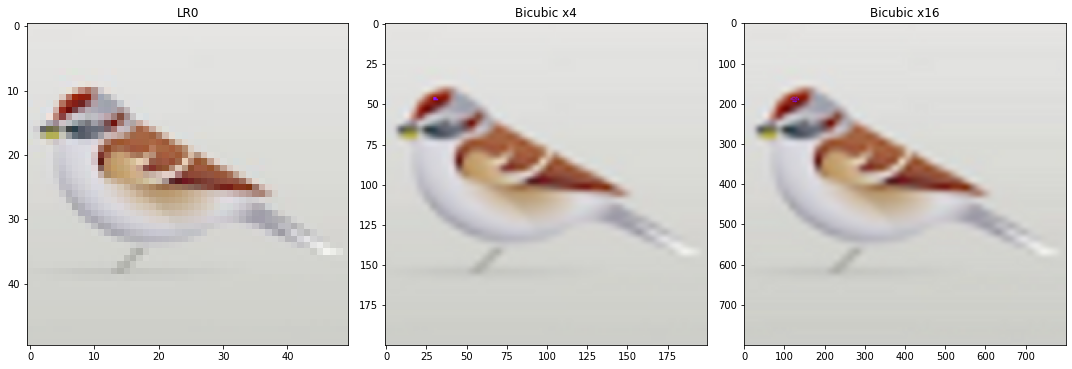

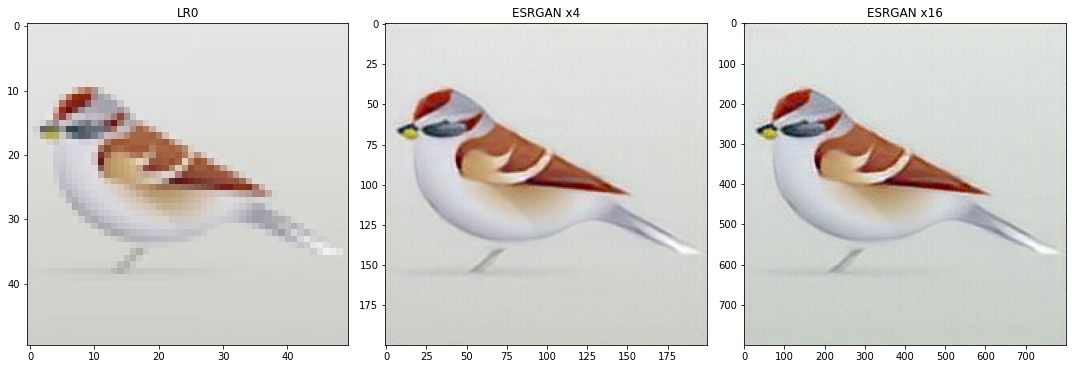

In [60]:
low2bicubic_low2super(lr0,sr1,sr2)

In [61]:
file_name='01_019.png'
lr0=get_resize_img(file_path+file_name,50)
lr0.shape

352256/351359 [==============================] - 0s 1us/step
mean: 144.307845


TensorShape([1, 50, 50, 3])

In [62]:
lr1,sr1=esrgantf2_superresolution(lr0)
lr1.shape,sr1.shape

(TensorShape([50, 50, 3]), TensorShape([200, 200, 3]))

In [ ]:
lr2,sr2=esrgantf2_superresolution(sr1)
lr2.shape,sr2.shape

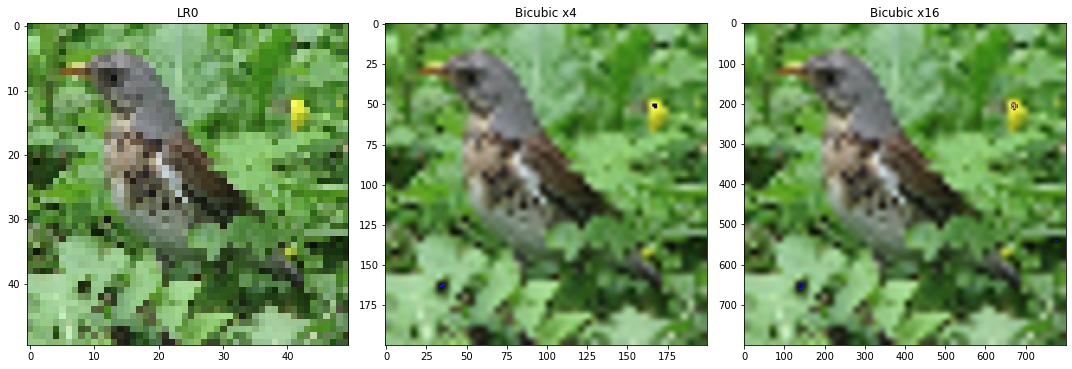

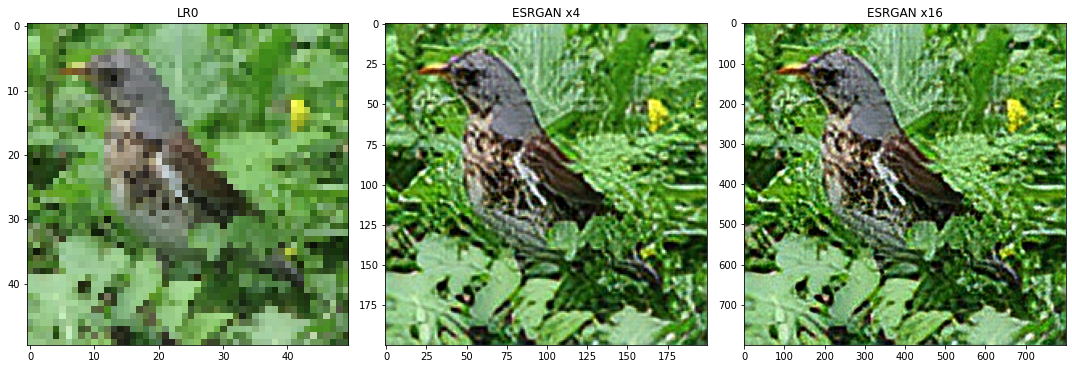

In [65]:
low2bicubic_low2super(lr0,sr1,sr2)